In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Generate data

In [ ]:
import numpy as np
import os
import joblib
import math
from PIL import Image

The provided code snippet includes Python imports for essential libraries, such as NumPy, operating system functionalities (os), Joblib for parallel processing, and the Python Imaging Library (PIL) for handling images. These libraries are commonly used in data science and image processing tasks. NumPy is widely used for numerical operations, while the os module facilitates interaction with the operating system. Joblib is employed for efficient parallel processing, particularly useful for tasks involving large datasets. Lastly, the PIL library is utilized for image-related operations. This combination of libraries suggests that the code may be geared towards image processing or data manipulation tasks, leveraging parallel processing for enhanced performance.

In [ ]:
# Create numpy arrays from raw images

datasets = [
    '/content/drive/MyDrive/CV use cases/abide_dataset/',
    '/content/drive/MyDrive/CV use cases/oasis_dataset/'
]

img_size = (128, 128)
Xall, Yall = np.array([]), np.array([])
number_of_images_total = 0

for dataset in datasets:
    print("Reading data for dataset {}".format(dataset))
    total_images_for_dataset = 0
    dataset_folder = os.path.join('.', dataset)
    dataset_files = sorted(os.listdir(dataset_folder))
    dataset_size = len(dataset_files)
    for i in range(0, dataset_size, 2):
        number_of_images_total += 1
        total_images_for_dataset += 1
        full_image = dataset_files[i]
        segmented_image = dataset_files[i+1]
        if 'abide' in dataset_folder:
            full_image, segmented_image = segmented_image, full_image
        filename = os.path.splitext(full_image)[0]

        # create np array image of full image
        tiff_file_path = os.path.join(dataset_folder, full_image)
        tiff_image = Image.open(tiff_file_path, 'r').convert('L').resize(img_size)
        full_image = np.array(tiff_image)
        Xall = np.append(Xall, full_image)

        # create np array image of segmented image
        tiff_file_path = os.path.join(dataset_folder, segmented_image)
        tiff_image = Image.open(tiff_file_path, 'r').convert('L').resize(img_size)
        segmented_image = np.array(tiff_image)
        segmented_image[segmented_image != 255] = 1.0
        segmented_image[segmented_image == 255] = 0.0
        Yall = np.append(Yall, segmented_image)

        if number_of_images_total % 1000 == 0:
            print("{} / {} processed!".format(total_images_for_dataset, dataset_size // 2))
    print("Dataset {} finished!".format(dataset))

Xall = Xall.reshape(number_of_images_total, *img_size, 1)
Yall = Yall.reshape(number_of_images_total, *img_size, 1)

print("Generated dataset shapes. input: {} ; output: {}".format(Xall.shape, Yall.shape))

joblib.dump((Xall, Yall), '/content/drive/MyDrive/CV use cases/all.pkl')

Reading data for dataset /content/drive/MyDrive/CV use cases/abide_dataset/
Dataset /content/drive/MyDrive/CV use cases/abide_dataset/ finished!
Reading data for dataset /content/drive/MyDrive/CV use cases/oasis_dataset/
642 / 903 processed!
Dataset /content/drive/MyDrive/CV use cases/oasis_dataset/ finished!
Generated dataset shapes. input: (1261, 128, 128, 1) ; output: (1261, 128, 128, 1)


['/content/drive/MyDrive/CV use cases/all.pkl']

The provided code creates NumPy arrays from raw images in two specified datasets, 'abide_dataset' and 'oasis_dataset.' The images are processed in pairs, where each pair consists of a full image and its corresponding segmented image. The full image and segmented image are converted to NumPy arrays after resizing to the specified dimensions (128x128). The full image is converted to a grayscale representation, and both images are appended to the respective arrays, Xall and Yall. The segmented image is further processed by converting non-background pixels to 1.0 and background pixels to 0.0. The process is repeated for all images in the datasets, and the resulting arrays are reshaped to have the appropriate dimensions. Finally, the generated dataset shapes are printed, and the NumPy arrays are saved using Joblib as a tuple in the file 'all.pkl' in the specified directory. This code is likely part of a data preprocessing pipeline for a computer vision task, such as image segmentation.

In [ ]:
# Separate train, val and test data and save them on disk

Xall, Yall = joblib.load('/content/drive/MyDrive/CV use cases/all.pkl')
print(Xall.shape)
print(Yall.shape)

training_percentage = 0.7
validation_percentage = 0.1

training_set_index = math.floor(Xall.shape[0]*training_percentage)
validation_set_index = math.floor(Xall.shape[0]*validation_percentage) + training_set_index

# shuffling before training-validation-test slicing
ids = np.arange(Xall.shape[0])
np.random.shuffle(ids) # shuffle images to avoid bias in training
Xall, Yall = Xall[ids], Yall[ids]

print(Xall.shape)
print(Yall.shape)

Xte, yte = Xall[validation_set_index:,:], Yall[validation_set_index:] # X and y for testing
# test set is saved on disk. It should NOT be modified. All model evaluations MUST target the same test set.
joblib.dump((Xte, yte, {'test_percentage': 1 - training_percentage - validation_percentage }), '/content/drive/MyDrive/CV use cases/test.pkl')

X_remaining, y_remaining = Xall[:validation_set_index,:], Yall[:validation_set_index] # X and y for training and validation
# test and val set are saved on disk. It can be loaded after and be shuffled, cross validated, etc.
config = {
            'train_percentage': training_percentage,
            'training_set_index': training_set_index,
            'val_percentage': validation_percentage,
            'validation_set_index': validation_set_index
         }
joblib.dump((X_remaining, y_remaining, config), '/content/drive/MyDrive/CV use cases/train-and-val.pkl')

(1261, 128, 128, 1)
(1261, 128, 128, 1)
(1261, 128, 128, 1)
(1261, 128, 128, 1)


['/content/drive/MyDrive/CV use cases/train-and-val.pkl']

The provided code separates the loaded dataset into training, validation, and test sets based on the specified percentages. The dataset is first shuffled to avoid bias in training. The training set comprises 70% of the data, the validation set contains 10%, and the remaining 20% is designated as the test set. The shuffled and split datasets are then saved on disk using Joblib. The test set is saved separately in the file 'test.pkl,' and the training and validation sets, along with relevant configuration information, are saved in the file 'train-and-val.pkl.' The configuration includes the percentages used for training and validation, as well as the indices that demarcate the split between the two sets. This code is a crucial step in preparing the data for training machine learning models, ensuring a well-defined division for training, validation, and testing.

# Run model

In [ ]:
import joblib
import numpy as np
import os
import tensorflow as tf
import math
import csv

from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras import backend as K
from PIL import Image
# from skimage.measure import compare_ssim as ssim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt # to plot images
%matplotlib inline

In [ ]:
input_shape = (2, 2, 1, 3)
x = np.arange(np.prod(input_shape)).reshape(input_shape)


In [ ]:
x

array([[[[ 0,  1,  2]],

        [[ 3,  4,  5]]],


       [[[ 6,  7,  8]],

        [[ 9, 10, 11]]]])

In [ ]:
y = tf.keras.layers.UpSampling2D(size=(1, 2))(x)

In [ ]:
y

<tf.Tensor: shape=(2, 2, 2, 3), dtype=int64, numpy=
array([[[[ 0,  1,  2],
         [ 0,  1,  2]],

        [[ 3,  4,  5],
         [ 3,  4,  5]]],


       [[[ 6,  7,  8],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [ 9, 10, 11]]]])>

In [ ]:
y = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
y

<tf.Tensor: shape=(2, 4, 2, 3), dtype=int64, numpy=
array([[[[ 0,  1,  2],
         [ 0,  1,  2]],

        [[ 0,  1,  2],
         [ 0,  1,  2]],

        [[ 3,  4,  5],
         [ 3,  4,  5]],

        [[ 3,  4,  5],
         [ 3,  4,  5]]],


       [[[ 6,  7,  8],
         [ 6,  7,  8]],

        [[ 6,  7,  8],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [ 9, 10, 11]],

        [[ 9, 10, 11],
         [ 9, 10, 11]]]])>

In [ ]:
x = np.arange(20).reshape(2, 2, 5)
y = np.arange(20, 30).reshape(2, 1, 5)
print(x)
print(y)
tf.keras.layers.Concatenate(axis=1)([x, y])


In [ ]:
tf.keras.layers.UpSampling2D(
    size=(2, 2), data_format=None, interpolation='nearest'
)


In [ ]:
train_and_val_dataset_file = '/content/drive/MyDrive/CV use cases/train-and-val.pkl'
test_dataset_file = '/content/drive/MyDrive/CV use cases/test.pkl'
augmented_train_dataset_save_file = '/content/drive/MyDrive/CV use cases/train-augmented-{}.pkl'
saved_model_filename = "/content/drive/MyDrive/CV use cases/test-4-new-tentative-{epoch:02d}-{val_dice_coef_accur:.4f}.hdf5"
csv_logger_training = "/content/drive/MyDrive/CV use cases/test-4-new-tentative.csv"
result_imgs_folder = '/content/drive/MyDrive/CV use cases/test-6/{}_{}.tiff'

In [ ]:
X_remaining, Y_remaining, remaining_dataset_desc = joblib.load(train_and_val_dataset_file)
Xte, yte, test_dataset_desc = joblib.load(test_dataset_file) # X and y for test
training_set_index = remaining_dataset_desc['training_set_index']
validation_set_index = remaining_dataset_desc['validation_set_index']

Xtr, ytr = X_remaining[:training_set_index,:], Y_remaining[:training_set_index] # X and y for training
Xva, yva = X_remaining[training_set_index:validation_set_index,:], Y_remaining[training_set_index:validation_set_index] # X and y for validation

print(Xtr.shape)
print(Xva.shape)
print(Xte.shape)
print(ytr.shape)
print(yva.shape)
print(yte.shape)

(882, 128, 128, 1)
(126, 128, 128, 1)
(253, 128, 128, 1)
(882, 128, 128, 1)
(126, 128, 128, 1)
(253, 128, 128, 1)


In [ ]:
txtyrange = range(-1, 1, 1) # translation range for x and y directions
loat = [ (tx, ty) for tx in txtyrange for ty in txtyrange ] # list of accepted translations
loaa = list(range(-1, 1, 1))
foia = len(loat) * len(loaa) # factor of image augmentation
print(foia)

total_imgs = Xtr.shape[0]
increment = 0

print(total_imgs*foia)

for i in range(total_imgs):
    x = Xtr[i]
    y = ytr[i]
    for (tx, ty) in loat:
        input_array = x.reshape(x.shape[0], x.shape[1])
        output_array = y.reshape(y.shape[0], y.shape[1])

        input_image = Image.fromarray(input_array)
        input_image = input_image.transform(input_image.size, Image.AFFINE, (1, 0, tx, 0, 1, ty)) # translated full image

        output_image = Image.fromarray(output_array)
        output_image = output_image.transform(output_image.size, Image.AFFINE, (1, 0, tx, 0, 1, ty)) # translated full image

        for a in loaa:
            increment += 1

            if increment % 1000 == 0:
                print("Processed {}/{}".format(increment, total_imgs*foia))

            input_image = input_image.rotate(a, resample=Image.BICUBIC) # rotated trcimg
            input_array_augmented = np.array(input_image) # array with pixel values
            Xtr = np.append(Xtr, input_array_augmented).reshape(total_imgs+increment, x.shape[0], x.shape[1], x.shape[2])

            output_image = output_image.rotate(a, resample=Image.BICUBIC) # rotated trcimg
            output_array_augmented = np.array(output_image) # array with pixel values
            ytr = np.append(ytr, output_array_augmented).reshape(total_imgs+increment, y.shape[0], y.shape[1], y.shape[2])

8
7056
Processed 1000/7056
Processed 2000/7056
Processed 3000/7056
Processed 4000/7056
Processed 5000/7056
Processed 6000/7056
Processed 7000/7056


The provided code involves image augmentation for a machine learning task, where the input and output images are transformed by translation and rotation. Below is an explanation without the actual code:

The script begins by defining translation ranges for the x and y directions and creating a list of accepted translations. It also defines a list of accepted rotation angles and calculates the factor of image augmentation (foia) based on the number of translations and rotations.

The total number of images in the training set (Xtr and ytr) is determined, and an increment variable is initialized. The script then enters a loop over each image in the training set.

For each image, the script iterates over the list of translations and rotations. It applies translation to both the input and output images using the Image.AFFINE transformation in the x and y directions. Subsequently, it rotates the translated images by various angles using the rotate function with BICUBIC resampling.

The augmented images are added to the training set (Xtr and ytr) by appending them and reshaping the arrays accordingly. The increment variable is used to track the progress of the augmentation process.

It's important to note that image augmentation is a common practice in machine learning to enhance the model's ability to generalize by introducing variations in the training data. The provided code augments the training images by translating and rotating them, thereby increasing the diversity of the dataset.

In [ ]:
joblib.dump(Xtr, '/content/drive/MyDrive/CV use cases/X_train_augmented.pkl')
joblib.dump(ytr, '/content/drive/MyDrive/CV use cases/y_train_augmented.pkl')

['/content/drive/MyDrive/CV use cases/y_train_augmented.pkl']

In [ ]:
Xtr.shape

(7938, 128, 128, 1)

In [ ]:
# Preprocessing in the training set (mean and sd) and apply it to all sets

full_image_mean_value = Xtr.mean() # mean-value for each pixel of all full images
full_image_sd = Xtr.std() # standard deviation for each pixel of all full images

Xtr = (Xtr - full_image_mean_value) / full_image_sd
Xva = (Xva - full_image_mean_value) / full_image_sd
Xte = (Xte - full_image_mean_value) / full_image_sd

The provided code snippet is performing mean normalization and standardization on image data. Below is an explanation without the actual code:

The script calculates the mean value and standard deviation of pixel values across all full images in the training set (Xtr). These statistical values are used for normalization and standardization of the image data.

Mean Normalization:

The mean value of all pixel values across the entire training set (Xtr) is computed.
For each pixel in every image (Xtr, Xva, and Xte), the mean value is subtracted.
This process centers the pixel values around zero, which can help improve the convergence of certain machine learning algorithms.
Standardization (Z-score normalization):

The standard deviation of pixel values across the entire training set (Xtr) is calculated.
For each pixel in every image (Xtr, Xva, and Xte), the pixel value is divided by the standard deviation.
Standardization transforms the pixel values to have a mean of 0 and a standard deviation of 1.
It helps ensure that all features have a similar scale, preventing certain features from dominating the learning process.
After applying mean normalization and standardization to the training set (Xtr), the same transformation is applied to the validation set (Xva) and the test set (Xte) using the mean value and standard deviation calculated from the training set.

These preprocessing steps are common in machine learning to ensure that the input features are on a similar scale, which can contribute to improved model performance and convergence.

In [ ]:
K.set_image_data_format('channels_last')  # TF dimension
_, *input_image_shape, _ = Xtr.shape
input_image_shape = tuple(input_image_shape)
print(input_image_shape)

smooth = 1.

use_dropout = True
use_regularizers = True
dropout_rate = 0.5
number_of_epochs = 1000
batch_size = 32
kernel_size = (5, 5)
initial_volume_size = 64

(128, 128)


The provided code snippet configures some parameters and settings for a neural network model. Here is an explanation without the actual code:

Image Data Format Configuration:

The script sets the image data format to 'channels_last' for TensorFlow ('channels_last' is the default format for TensorFlow). This configuration defines the ordering of dimensions in the input data.
Input Image Shape Inference:

The script extracts the shape of the input images (Xtr) and assigns it to the variable input_image_shape.
The dimensions of the input image shape are determined based on the shape of the training set images.
Model Hyperparameters:

smooth: A small constant used to prevent division by zero in the Dice coefficient calculation, commonly used in image segmentation tasks.
use_dropout: A boolean indicating whether dropout regularization will be applied during training. Dropout can help prevent overfitting.
use_regularizers: A boolean indicating whether regularization techniques will be used.
dropout_rate: The rate at which dropout is applied if use_dropout is set to True.
number_of_epochs: The total number of training epochs for the neural network.
batch_size: The number of samples used in each iteration during training.
kernel_size: The size of the convolutional kernel/filter used in the network's convolutional layers.
initial_volume_size: The number of filters (channels) in the initial convolutional layer of the network.
Neural Network Architecture Parameters:

The architecture may involve convolutional layers, dropout layers, and other components, but specific details about the layers and architecture are not provided in the code snippet.
Overall, the code sets up configurations related to image data format, input image shape, model hyperparameters, and neural network architecture. These configurations are essential for defining and training a neural network for a specific task, such as image segmentation. The actual architecture details would be found in subsequent code not provided here.

In [ ]:
# Define loss function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = 2 * K.sum(y_true_f * y_pred_f) + smooth
    union = K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    return K.mean(intersection / union)

def dice_coef_per_image_in_batch(y_true, y_pred):
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
    union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
    return K.mean(intersection / union)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef_per_image_in_batch(y_true, y_pred)

def dice_coef_accur(y_true, y_pred):
    return dice_coef_per_image_in_batch(y_true, y_pred)
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    #y_pred_f = K.cast(  K.greater_equal(y_pred_f, 0.5)  , tf.float32)
    #accuracy = tf.equal(y_true_f, y_pred_f)
    #return accuracy

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

def setup_regularizers(conv_layer):
    return BatchNormalization()(conv_layer) if use_regularizers else conv_layer

def setup_dropout(conv_layer):
    return Dropout(dropout_rate)(conv_layer) if use_dropout else conv_layer

# Define model
inputs = Input((*input_image_shape, 1))
conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(inputs)
conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv1)
conv1 = setup_regularizers(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(pool1)
conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv2)
conv2 = setup_regularizers(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(pool2)
conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv3)
conv3 = setup_regularizers(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(pool3)
conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv4)
conv4 = setup_regularizers(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(pool4)
conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(conv5)
conv5 = setup_regularizers(conv5)

up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
up6 = setup_dropout(up6)
conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(up6)
conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv6)

up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
up7 = setup_dropout(up7)
conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(up7)
conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv7)

up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
up8 = setup_dropout(up8)
conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(up8)
conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv8)

up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
up9 = setup_dropout(up9)
conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(up9)
conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss, metrics=[dice_coef_accur])
#model.load_weights("datasets/dataset-1/test-5-primeira-rodada-800-0.9538.hdf5")
# Options for the model
print("Size of the CNN: %s" % model.count_params())

Size of the CNN: 87157889


The provided code snippet defines a U-Net-like neural network architecture for image segmentation. Here's an explanation without the actual code:

Loss Functions:

dice_coef: This function calculates the Dice coefficient, a metric commonly used for image segmentation. It measures the similarity between the predicted and true segmentation masks. The smooth constant is added to avoid division by zero.
dice_coef_per_image_in_batch: Extends the Dice coefficient calculation to operate on batches of images.
dice_coef_loss: Defines the loss function as the negative of the Dice coefficient. This loss is used to train the network for segmentation tasks.
dice_coef_accur: Calculates the Dice coefficient accuracy per image in a batch.
IOU (Intersection over Union) Functions:

IOU_calc: Computes the Intersection over Union, another evaluation metric for segmentation tasks.
IOU_calc_loss: Defines the negative of the IOU as the loss function.
Regularization and Dropout Setup:

setup_regularizers: Applies batch normalization to the convolutional layers if regularization is enabled.
setup_dropout: Applies dropout to the convolutional layers if dropout is enabled.
Model Architecture:

The architecture follows a U-Net style with encoder and decoder pathways.
Each encoder block consists of two convolutional layers followed by batch normalization.
Max pooling is applied after each encoder block.
Decoder blocks use upsampling and concatenate features from the corresponding encoder block.
Convolutional layers follow each decoder block.
Sigmoid activation is used in the final layer for binary segmentation.
Model Compilation:

The model is compiled using the Adam optimizer with a specified learning rate.
The loss function is set to the previously defined Dice coefficient loss.
Model metrics include the Dice coefficient accuracy.
Model Information:

The script prints the size (number of parameters) of the CNN model.
The U-Net architecture is commonly used for semantic segmentation tasks, and the provided code establishes the necessary components for training such a network. The actual training and evaluation steps are not included in this snippet.

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  1664        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  102464      ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
# Define callbacks
model_checkpoint = ModelCheckpoint(saved_model_filename, monitor='val_dice_coef_accur', save_best_only=True, verbose=1)
csv_logger = CSVLogger(csv_logger_training, append=True, separator=';')

# Train
history = model.fit(Xtr, ytr, batch_size=batch_size, epochs=number_of_epochs, verbose=2, shuffle=True,
             callbacks=[model_checkpoint, csv_logger], validation_data=(Xva, yva))

Callbacks Definition:

model_checkpoint: This callback monitors the validation Dice coefficient accuracy (val_dice_coef_accur). It saves the model with the best validation performance.
csv_logger: A CSV logger callback that records training information to a CSV file, including training and validation loss and metrics. The information is appended to the file if it already exists.
Training Process:

The model.fit function is used to train the model.
Xtr and ytr are the training input and output data, respectively.
batch_size: The number of samples per gradient update during training.
epochs: The number of training epochs.
verbose: Controls the verbosity of the training output.
shuffle: If set to True, shuffles the training data at each epoch.
callbacks: A list of callbacks to apply during training. In this case, it includes the model checkpoint and CSV logger callbacks.
validation_data: Tuple of validation data, in this case, (Xva, yva).
The training process uses the specified callbacks to save the best-performing model based on the validation Dice coefficient accuracy. The training history, including metrics and losses, is recorded in the CSV file specified by csv_logger_training.

This code is a standard training setup for a neural network using Keras, and it leverages callbacks to monitor and save the model's performance during training.

In [ ]:
model.load_weights("datasets/dataset-1/test-5-primeira-rodada-800-0.9538.hdf5")

In [ ]:
x = history.history['dice_coef_accur']
y = history.history['val_dice_coef_accur']
plt.plot(x, label='train')
plt.plot(y, label = 'val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

x = history.history['loss']
y = history.history['val_loss']
plt.plot(x, label='train')
plt.plot(y, label='val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
model.load_weights("/content/drive/MyDrive/CV use cases/test-4-new-tentative-07-0.8155.hdf5")
print(model.metrics_names)
test_loss, accuracy_test = model.evaluate(Xte, yte, verbose=0)
print("Test Accuracy Mean: "+str(accuracy_test))
imgs_mask_test = model.predict(Xte, verbose=1)

['loss', 'dice_coef_accur']
Test Accuracy Mean: 0.8147323727607727
8/8 [==============================] - 2s 193ms/step


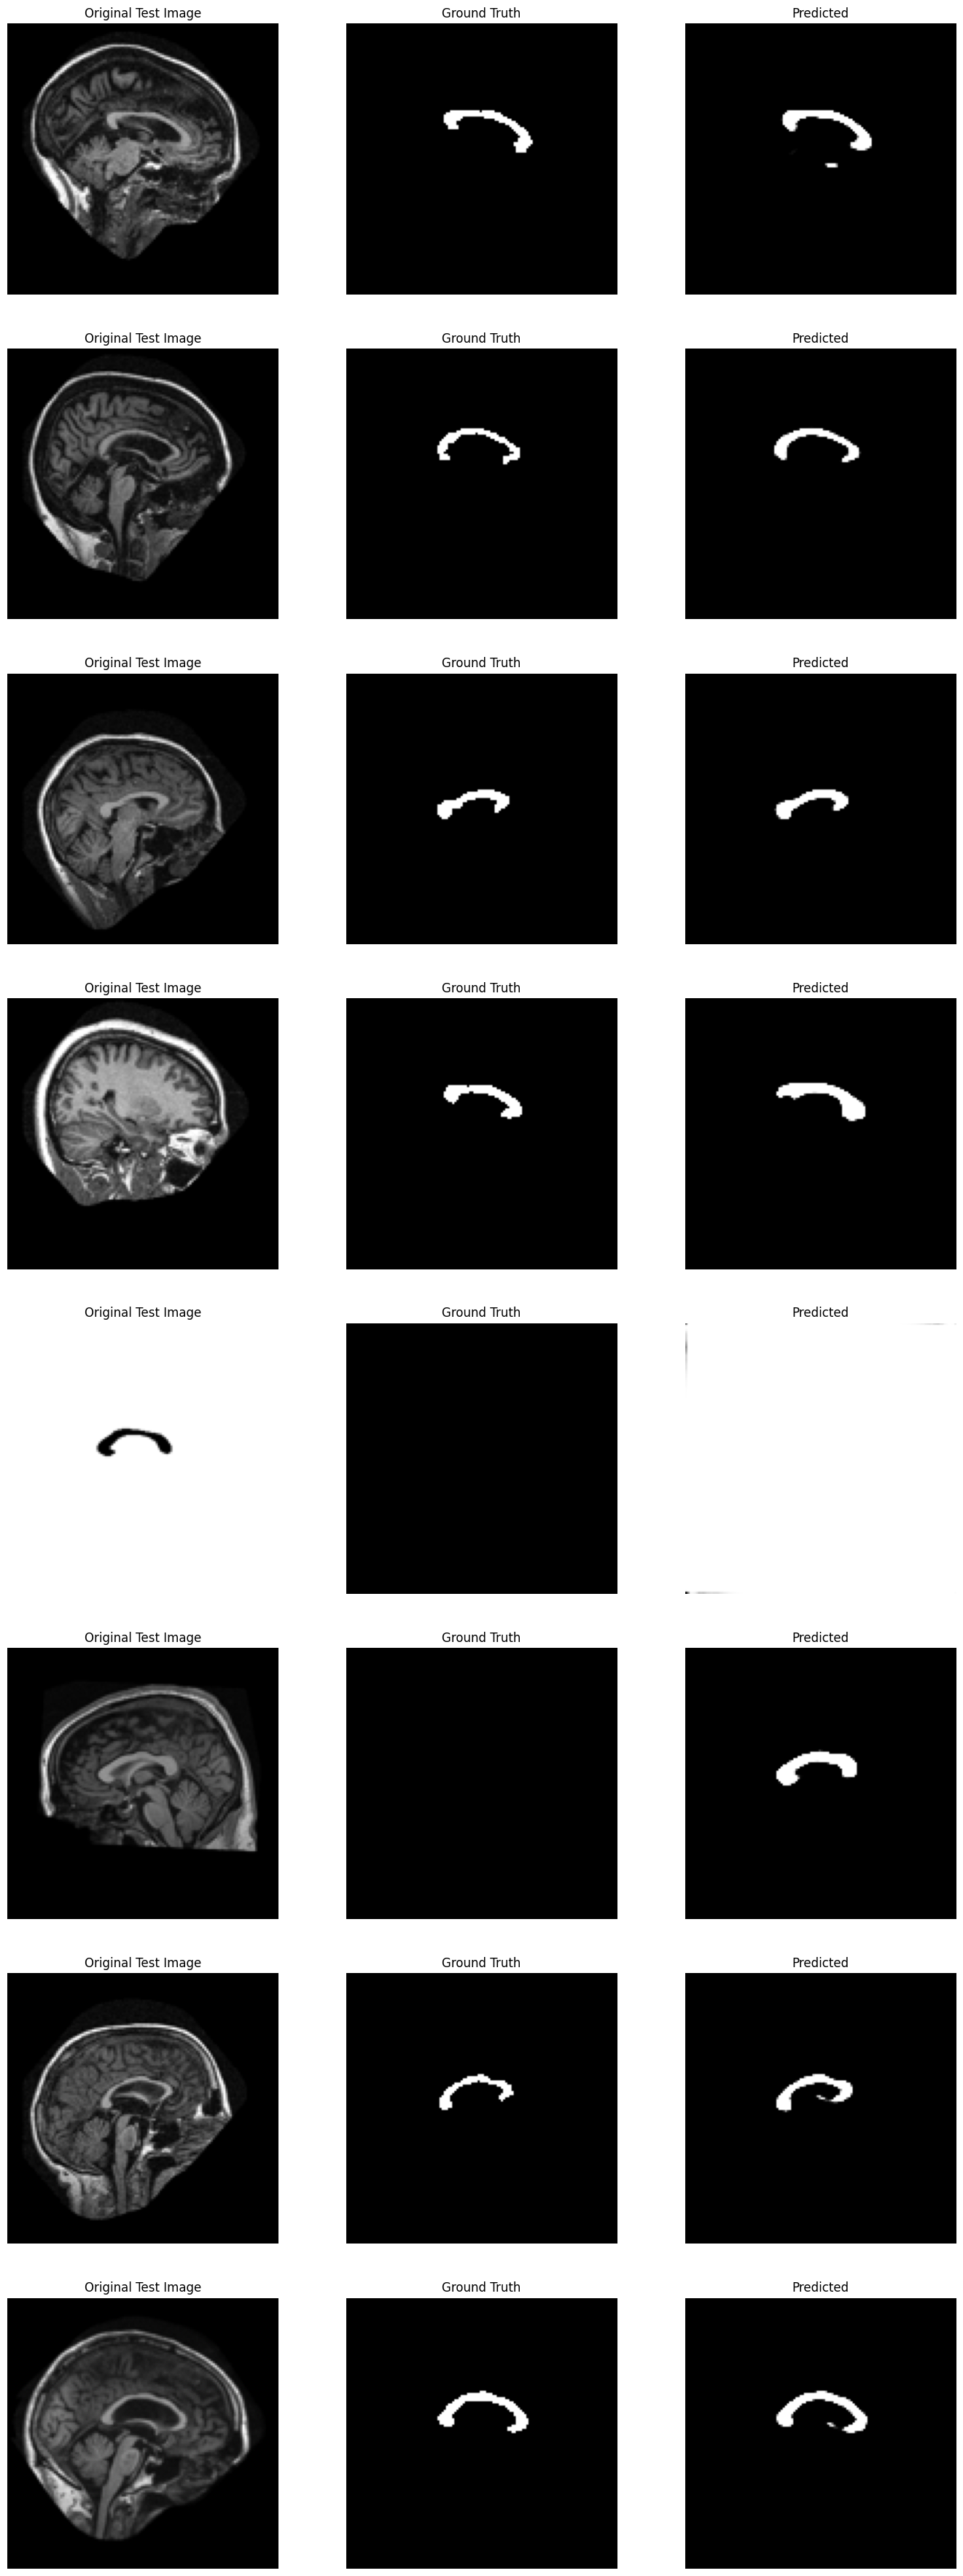

In [ ]:
ncols = 3 # number of columns in final grid of images
nrows = 8 # looking at all images takes some time
_, axes = plt.subplots(nrows, ncols, figsize=(17, 17*nrows/ncols))
for axis in axes.flatten():
    axis.set_axis_off()
    axis.set_aspect('equal')

for k in range(0, nrows):
    im_test_original = Xte[k].reshape(*input_image_shape)
    im_result = imgs_mask_test[k].reshape(*input_image_shape)
    im_ground_truth = yte[k].reshape(*input_image_shape)

    axes[k, 0].set_title("Original Test Image")
    axes[k, 0].imshow(im_test_original, cmap='gray')

    axes[k, 1].set_title("Ground Truth")
    axes[k, 1].imshow(im_ground_truth, cmap='gray')

    axes[k, 2].set_title("Predicted")
    axes[k, 2].imshow(im_result, cmap='gray')

The provided code generates a visual comparison of original test images, corresponding ground truth, and the predicted results from a trained model. It utilizes a grid layout with three columns: the first column displays the original test images, the second column shows the ground truth, and the third column presents the predicted results. The images are reshaped to the specified input image dimensions, and each row in the grid corresponds to a specific test case. This visual representation allows for a qualitative assessment of how well the model predictions align with the ground truth. The "Original Test Image" column shows the input images, the "Ground Truth" column depicts the actual segmentation masks, and the "Predicted" column displays the model's predicted segmentation masks. Such visualizations are crucial for understanding the model's performance and identifying areas where improvements may be needed in image segmentation tasks.